In [22]:
import sys
sys.path.insert(0, '..')

In [23]:
from pyphoon.db import pd_manager
import pandas as pd
import numpy as np
from pyphoon.io.h5 import read_source_image

In [24]:
orig_images_dir = '../../../../datasets/typhoon/wnp/image/'
corrected_dir = '../../../database/corrected'
db_dir = '../../../database/'

In [25]:
from os.path import exists, join
images = join(db_dir, 'images.pkl')
corrupted = join(db_dir, 'corrupted.pkl')

In [26]:
pd_man = pd_manager.PDManager()
pd_man.load_images(images)
pd_man.load_corrupted(corrupted)

In [27]:
joined = pd_man.images.join(pd_man.corrupted, how='inner')

In [28]:
joined.head()

directory                     filename    size  \
seq_no obs_time                                                             
197901 1979-01-03 16:00:00    197901  1979010316-197901-GMS1-1.h5  282481   
       1979-01-06 21:00:00    197901  1979010621-197901-GMS1-1.h5  254187   
       1979-01-07 06:00:00    197901  1979010706-197901-GMS1-1.h5  256038   
197902 1979-03-22 03:00:00    197902  1979032203-197902-GMS1-1.h5  242027   
       1979-03-22 06:00:00    197902  1979032206-197902-GMS1-1.h5  242848   

                                    corrupted  corruption  
seq_no obs_time                                            
197901 1979-01-03 16:00:00  197901_1979010316    0.004311  
       1979-01-06 21:00:00  197901_1979010621    0.002281  
       1979-01-07 06:00:00  197901_1979010706    0.000004  
197902 1979-03-22 03:00:00  197902_1979032203    0.000328  
       1979-03-22 06:00:00  197902_1979032206    0.000103

In [29]:
import matplotlib.pyplot as plt

In [30]:
%matplotlib inline

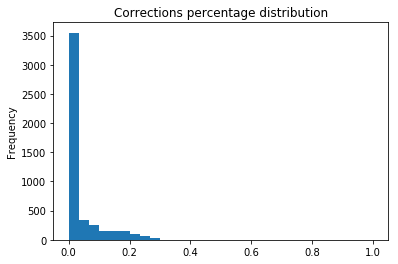

In [31]:
pd_man.corrupted.corruption.plot.hist(bins=30, title='Corrections percentage distribution')

## Discard slightly corrected images

In [32]:
discard_less_than = 0.01
signif_cor = pd_man.corrupted.loc[pd_man.corrupted.corruption >= discard_less_than, :]

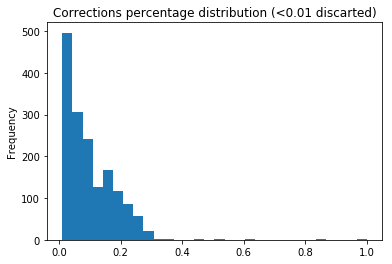

In [33]:
signif_cor.corruption.plot.hist(bins=30, title=('Corrections percentage distribution (<{0} discarted)').format(discard_less_than))

In [34]:
signif_cor.corruption.describe()

count    1629.000000
mean        0.099232
std         0.082452
min         0.010029
25%         0.034916
50%         0.077991
75%         0.154507
max         1.000000
Name: corruption, dtype: float64

In [35]:
bins = np.linspace(0, 1, num=30, endpoint=True)

In [36]:
bins

array([ 0.        ,  0.03448276,  0.06896552,  0.10344828,  0.13793103,
        0.17241379,  0.20689655,  0.24137931,  0.27586207,  0.31034483,
        0.34482759,  0.37931034,  0.4137931 ,  0.44827586,  0.48275862,
        0.51724138,  0.55172414,  0.5862069 ,  0.62068966,  0.65517241,
        0.68965517,  0.72413793,  0.75862069,  0.79310345,  0.82758621,
        0.86206897,  0.89655172,  0.93103448,  0.96551724,  1.        ])

In [37]:

signif_cor['bins']=pd.cut(bins=bins, x=signif_cor.corruption)

/fs9/grishin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [38]:
binned = signif_cor.groupby(signif_cor.bins)

In [39]:
largest = binned.size().argmax()

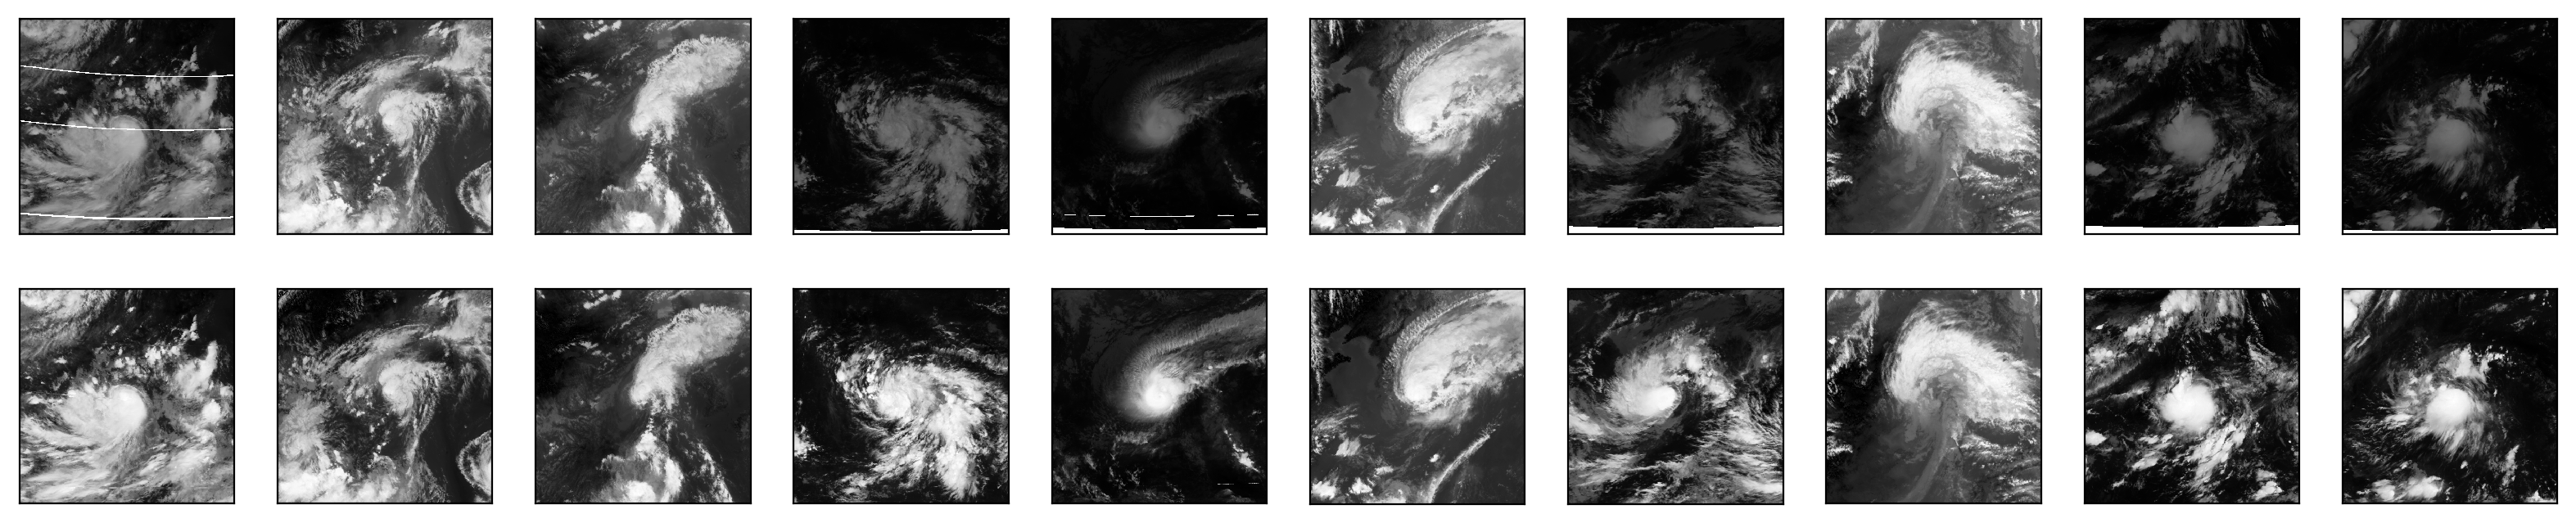

In [40]:
from os.path import join
n=10
seed = 1
images = binned.get_group(largest).sample(n=n, random_state=seed)
files = images.join(pd_man.images).loc[:, ['directory', 'filename']]
orig_images = [read_source_image(join(orig_images_dir, x[1].directory, x[1].filename)) for x in files.iterrows()]
corrected_images = [read_source_image(join(corrected_dir, x[1].directory, x[1].filename)) for x in files.iterrows()]

plt.figure(figsize=(20, 4), dpi=200)
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(orig_images[i], cmap="Greys")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display corrected
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(corrected_images[i], cmap="Greys")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig(('correction{0}.png').format(seed))
plt.show()


In [41]:
pix_vals = pd.DataFrame()
for i in range(0, len(files)):
    pix_vals.loc[i, 'dir'] = files.iloc[i, 0]
    pix_vals.loc[i, 'file'] = files.iloc[i, 1]
    pix_vals.loc[i, 'orig_mean'] = orig_images[i].mean()
    pix_vals.loc[i, 'corr_mean'] = corrected_images[i].mean()
    pix_vals.loc[i, 'orig_min'] = orig_images[i].min()
    pix_vals.loc[i, 'corr_min'] = corrected_images[i].min()
    pix_vals.loc[i, 'orig_max'] = orig_images[i].max()
    pix_vals.loc[i, 'corr_max'] = corrected_images[i].max()


In [42]:
pix_vals

,dir,file,orig_mean,corr_mean,orig_min,corr_min,orig_max,corr_max
0,201108,2011072909-201108-MTS2-1.h5,249.156709,251.728872,113.245140,176.919780,302.642776,302.642776
1,198708,1987072808-198708-GMS3-1.h5,267.996215,267.774605,180.496353,180.496353,318.856938,309.653395
2,201210,2012080306-201210-MTS2-1.h5,278.571035,278.413560,187.336650,187.336650,318.382033,309.973800
3,198720,1987101601-198720-GMS3-1.h5,263.752594,268.298733,-16.794000,180.704108,299.668017,299.668017
4,198801,1988011408-198801-GMS3-1.h5,276.449018,284.209929,-12.746000,182.413713,300.703120,300.703120
5,199708,1997062805-199708-GMS5-1.h5,274.041772,273.863584,197.844237,197.844237,318.644445,309.801558
6,199026,1990111104-199026-GMS4-1.h5,256.469775,265.178709,-18.273000,176.984914,299.145527,299.145527
7,199713,1997082105-199713-GMS5-1.h5,279.201673,279.106222,220.968295,220.968295,314.641336,309.815845
8,198704,1987062622-198704-GMS3-1.h5,259.771813,270.214268,-20.543000,178.239503,298.351024,298.351024
9,198805,1988062801-198805-GMS3-1.h5,270.217469,274.990429,-14.116000,180.341076,297.757977,297.757977


In [43]:
pix_vals.shape

(10, 8)

In [44]:
from pyphoon.io.typhoonlist import create_typhoonlist_from_source

In [45]:
seq = create_typhoonlist_from_source(name='200004', 
                                     images='../../../../datasets/typhoon/wnp/image/200004/'
                                     )

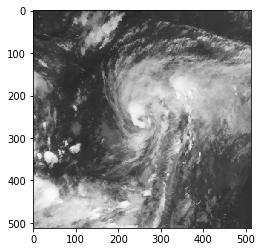

In [46]:
plt.imshow(seq.get_data('images', id='200004_2000070911'), cmap="Greys")

In [47]:
from pyphoon.io.h5 import read_source_image

In [48]:
wrong_seq_folder = '../../../database/corrected/200004/'
orig_seq_folder = '../../../../datasets/typhoon/wnp/image/200004/'

In [49]:
from pyphoon.clean.fix import TyphoonListImageFixAlgorithm
from pyphoon.clean.detection import detect_corrupted_pixels_1
from pyphoon.clean.correction import correct_corrupted_pixels_1
# Define algorithm
fix_algorithm = TyphoonListImageFixAlgorithm(
    detect_fct=detect_corrupted_pixels_1,
    correct_fct=correct_corrupted_pixels_1,
    detect_params={'min_th': 160, 'max_th': 310},
    n_frames_th=2
)

# Apply fixing algorithm
sequence_corrected = fix_algorithm.apply(seq)

In [50]:
from os import listdir
from os.path import isfile
files = [f for f in listdir(wrong_seq_folder) if f.endswith('.h5') and isfile(join(wrong_seq_folder, f))]

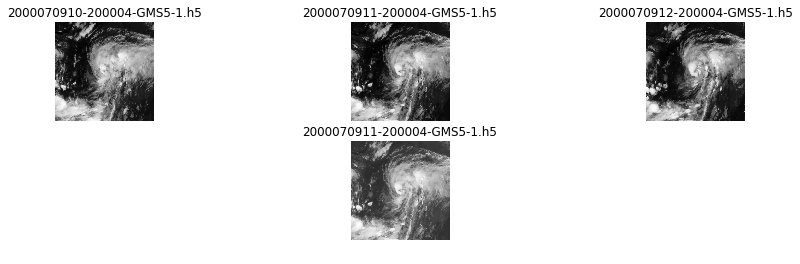

In [51]:
index = 2
f = files[index]
entry = pd_man.images.loc[pd_man.images.filename==f].iloc[-1]
loc = pd_man.images.index.get_loc(entry.name)
f_prev = pd_man.images.iloc[loc-1].filename
f_next = pd_man.images.iloc[loc+1].filename
prev_ = read_source_image(join(orig_seq_folder, f_prev))
next_ = read_source_image(join(orig_seq_folder, f_next))
original_image = read_source_image(join(orig_seq_folder, f))
corrected_image = read_source_image(join(wrong_seq_folder, f))
plt.figure(figsize=(15, 4))
plt.subplot(231)
plt.title(f_prev)
plt.axis('off')
plt.imshow(prev_, cmap="Greys", )
plt.subplot(232)
plt.axis('off')
plt.title(f)
plt.imshow(corrected_image, cmap="Greys", )
plt.subplot(235)
plt.axis('off')
plt.title(f)
plt.imshow(original_image, cmap="Greys", )
plt.subplot(233)
plt.title(f_next)
plt.axis('off')
plt.imshow(next_, cmap="Greys")
